Example of script to make a violin plot of number of UMI per spot.<br>

Input files are downsampled.<br>

data files needed to run are available at SCP: https://singlecell.broadinstitute.org/single_cell/study/SCP979/<br>
please download:<br>
10015CN108_C1_stdata.tsv<br>
10015CN108fl_E2_stdata.tsv<br>
5005CN107_D2_stdata.tsv <br>
visium_A1_stdata.tsv<br>
visium_B1_stdata.tsv  <br>
visium_D1_stdata.tsv<br>
10015CN108_C1_annotations.txt<br> 
10015CN108fl_E2_annotations.txt<br>
5005CN107_D2_annotations.txt<br> 
visium_A1_annotations.txt<br> 
visium_B1_annotations.txt<br>
visium_D1_annotations.txt<br>

In [1]:
%matplotlib inline
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import matplotlib as mpl
import matplotlib.patches as mpatches

In [30]:
from matplotlib.text import Text
from matplotlib import transforms, lines
import matplotlib.transforms as mtransforms
from matplotlib.font_manager import FontProperties
from seaborn.utils import remove_na

from scipy import stats
DEFAULT = object()


def stat_test(box_data1, box_data2, test):
    test_short_name = ''
    formatted_output = None
    if test == 'Wilcoxon':
        u_stat, pval = stats.ranksums(box_data1, box_data2)
        test_short_name = 'Wilcox'
        formatted_output = ("Wilcoxon test P_val={:.3e} U_stat={:.3e}"
                           .format(pval, u_stat))
        
    elif test == 'ttest':
        u_stat, pval = stats.ttest_ind(box_data1, box_data2, equal_var=False)
        test_short_name = 'T-test'
        formatted_output = ("T-test P_val={:.3e} U_stat={:.3e}"
                           .format(pval, u_stat))
    return pval, u_stat,formatted_output, test_short_name


def pval_annotation_text(x, pvalue_thresholds):
    singleValue = False
    if type(x) is np.array:
        x1 = x
    else:
        x1 = np.array([x])
        singleValue = True
    # Sort the threshold array
    pvalue_thresholds = pd.DataFrame(pvalue_thresholds).sort_values(by=0, ascending=False).values
    x_annot = pd.Series(["" for _ in range(len(x1))])
    for i in range(0, len(pvalue_thresholds)):
        if (i < len(pvalue_thresholds)-1):
            condition = (x1 <= pvalue_thresholds[i][0]) & (pvalue_thresholds[i+1][0] < x1)
            x_annot[condition] = pvalue_thresholds[i][1]
        else:
            condition = x1 < pvalue_thresholds[i][0]
            x_annot[condition] = pvalue_thresholds[i][1]

    return x_annot if not singleValue else x_annot.iloc[0]


def simple_text(pval, pvalue_format, pvalue_thresholds, test_short_name=None):
    """
    Generates simple text for test name and pvalue
    :param pval: pvalue
    :param pvalue_format: format string for pvalue
    :param test_short_name: Short name of test to show
    :param pvalue_thresholds: String to display per pvalue range
    :return: simple annotation
    """
    # Sort thresholds
    thresholds = sorted(pvalue_thresholds, key=lambda x: x[0])

    # Test name if passed
    text = test_short_name and test_short_name + " " or ""

    for threshold in thresholds:
        if pval < threshold[0]:
            pval_text = "p ≤ {}".format(threshold[1])
            break
    else:
        pval_text = "p = {}".format(pvalue_format).format(pval)

    #return text + pval_text
    return pval_text


def add_stat_annotation(ax,
                        data=None, x=None, y=None, hue=None, order=None, hue_order=None,
                        box_pairs=None,
                        test='t-test_welch', text_format='star', pvalue_format_string=DEFAULT,
                        loc='inside', show_test_name=True, pvalue_thresholds=DEFAULT,
                        use_fixed_offset=False, line_offset_to_box=None, line_offset=None,
                        line_height=0.02, text_offset=1, stack=True,
                        color='0.2', linewidth=1.5, fontsize='medium', verbose=1):
    """
    User should use the same argument for the data, x, y, hue, order, hue_order as the seaborn boxplot function.
    line_height is in axes fraction coordinates.
    text_offset is in points.
    box_pairs can be of either form:
    For non-grouped boxplot: [(cat1, cat2), (cat3, cat4)]
    For boxplot grouped by hue: [((cat1, hue1), (cat2, hue2)), ((cat3, hue3), (cat4, hue4))]
    Default pvalue_format_string is "{.3e}".
    pvalue_thresholds is a list of lists or tuples. Default is:
    For "star" text_format:
        [[1e-4, "****"], [1e-3, "***"], [1e-2, "**"], [0.05, "*"], [1, "ns"]]
    For "simple" text_format :
        [[1e-5, "1e-5"], [1e-4, "1e-4"], [1e-3, "0.001"], [1e-2, "0.01"]]
    """

    def find_x_position_box(box_plotter, boxName):
        """
        boxName can be either a name "cat" or a tuple ("cat", "hue")
        """
        if box_plotter.plot_hues is None:
            cat = boxName
            hueOffset = 0
        else:
            cat = boxName[0]
            hue = boxName[1]
            hueOffset = box_plotter.hue_offsets[box_plotter.hue_names.index(hue)]

        groupPos = box_plotter.group_names.index(cat)
        boxPos = groupPos + hueOffset
        return boxPos


    def get_box_data(box_plotter, boxName):
        """
        boxName can be either a name "cat" or a tuple ("cat", "hue")
        Here we really have to duplicate seaborn code, because there is not direct access to the
        box_data in the BoxPlotter class.
        """
        if box_plotter.plot_hues is None:
            cat = boxName
        else:
            cat = boxName[0]
            hue = boxName[1]

        i = box_plotter.group_names.index(cat)
        group_data = box_plotter.plot_data[i]

        if box_plotter.plot_hues is None:
            # Draw a single box or a set of boxes
            # with a single level of grouping
            box_data = remove_na(group_data)
        else:
            hue_level = hue
            hue_mask = box_plotter.plot_hues[i] == hue_level
            box_data = remove_na(group_data[hue_mask])

        return box_data

    # Set default values if necessary
    if pvalue_format_string is DEFAULT:
        pvalue_format_string = '{:.3e}'
        simple_format_string = '{:.2f}'
    else:
        simple_format_string = pvalue_format_string

    if pvalue_thresholds is DEFAULT:
        if text_format == "star":
            pvalue_thresholds = [[1e-4, "****"], [1e-3, "***"],
                                 [1e-2, "**"], [0.05, "*"], [1, "ns"]]
        else:
            pvalue_thresholds = [[1e-5, "1e-5"], [1e-4, "1e-4"],
                                 [1e-3, "0.001"], [1e-2, "0.01"]]
    
    fig = plt.gcf()

    valid_list = ['inside', 'outside']
    if loc not in valid_list:
        raise ValueError("loc value should be one of the following: {}.".format(', '.join(valid_list)))
    valid_list = ['Wilcoxon', 'ttest']
    if test not in valid_list:
        raise ValueError("test value should be one of the following: {}.".format(', '.join(valid_list)))

    if verbose >= 1 and text_format == 'star':
        print("pvalue annotation legend:")
        pvalue_thresholds = pd.DataFrame(pvalue_thresholds).sort_values(by=0, ascending=False).values
        for i in range(0, len(pvalue_thresholds)):
            if (i < len(pvalue_thresholds)-1):
                print('{}: {:.2e} < p <= {:.2e}'.format(pvalue_thresholds[i][1], pvalue_thresholds[i+1][0], pvalue_thresholds[i][0]))
            else:
                print('{}: p <= {:.2e}'.format(pvalue_thresholds[i][1], pvalue_thresholds[i][0]))
        print()

    # Create the same BoxPlotter object as seaborn's boxplot
    box_plotter = sns.categorical._BoxPlotter(x, y, hue, data, order, hue_order,
                                              orient=None, width=.8, color=None, palette=None, saturation=.75,
                                              dodge=True, fliersize=5, linewidth=None)
    print(box_plotter.group_names, box_plotter.hue_names)
    ylim = ax.get_ylim()
    yrange = ylim[1] - ylim[0]

    if line_offset is None:
        if loc == 'inside':
            line_offset = 0.05
            if line_offset_to_box is None:
                line_offset_to_box = 0.06
        elif loc == 'outside':
            line_offset = 0.03
            line_offset_to_box = line_offset
    else:
        if loc == 'inside':
            if line_offset_to_box is None:
                line_offset_to_box = 0.06
        elif loc == 'outside':
            line_offset_to_box = line_offset
    y_offset = line_offset*yrange
    y_offset_to_box = line_offset_to_box*yrange

    y_stack = []
    annList = []
    test_result_list = []
    for box1, box2 in box_pairs:

        valid = None
        group_names = box_plotter.group_names
        hue_names = box_plotter.hue_names
        if box_plotter.plot_hues is None:
            cat1 = box1
            cat2 = box2
            hue1 = None
            hue2 = None
            label1 = '{}'.format(cat1)
            label2 = '{}'.format(cat2)
            valid = cat1 in group_names and cat2 in group_names
        else:
            cat1 = box1[0]
            hue1 = box1[1]
            cat2 = box2[0]
            hue2 = box2[1]
            label1 = '{}_{}'.format(cat1, hue1)
            label2 = '{}_{}'.format(cat2, hue2)
            valid = cat1 in group_names and cat2 in group_names and hue1 in hue_names and hue2 in hue_names

        if valid:
            # Get position of boxes
            x1 = find_x_position_box(box_plotter, box1)
            x2 = find_x_position_box(box_plotter, box2)
            box_data1 = get_box_data(box_plotter, box1)
            box_data2 = get_box_data(box_plotter, box2)
            ymax1 = box_data1.max()
            ymax2 = box_data2.max()

            pval, u_stat,formatted_output, test_short_name = stat_test(box_data1, box_data2, test)
            test_result_list.append({'pvalue':pval, 'test_short_name':test_short_name,
                                   'formatted_output':formatted_output, 'box1':box1, 'box2':box2})
            if verbose >= 1:
                print("{} v.s. {}: {}".format(label1, label2, formatted_output))

            if text_format == 'full':
                text = "{} p = {}".format('{}', pvalue_format_string).format(test_short_name, pval)
            elif text_format is None:
                text = None
            elif text_format is 'star':
                text = pval_annotation_text(pval, pvalue_thresholds)
            elif text_format is 'simple':
                test_short_name = show_test_name and test_short_name or ""
                text = simple_text(pval, simple_format_string, pvalue_thresholds,
                                   test_short_name)

            if loc == 'inside':
                yref = max(ymax1, ymax2)
            elif loc == 'outside':
                yref = ylim[1]

            if stack:
                if len(y_stack) > 0:
                    yref2 = max(yref, max(y_stack))
                else:
                    yref2 = yref
            else:
                yref2 = yref

            if len(y_stack) == 0:
                y = yref2 + y_offset_to_box
            else:
                y = yref2 + y_offset
            h = line_height*yrange
            lineX, lineY = [x1, x1, x2, x2], [y, y + h, y + h, y]
            if loc == 'inside':
                ax.plot(lineX, lineY, lw=linewidth, c=color)
            elif loc == 'outside':
                line = lines.Line2D(lineX, lineY, lw=linewidth, c=color, transform=ax.transData)
                line.set_clip_on(False)
                ax.add_line(line)

            if text is not None:
                ann = ax.annotate(text, xy=(np.mean([x1, x2]), y + h),
                                  xytext=(0, text_offset), textcoords='offset points',
                                  xycoords='data', ha='center', va='bottom', fontsize=fontsize,
                                  clip_on=False, annotation_clip=False)
                annList.append(ann)

            ax.set_ylim((ylim[0], 1.1*(y + h)))

            if text is not None:
                plt.draw()
                y_top_annot = None
                got_mpl_error = False
                if not use_fixed_offset:
                    try:
                        bbox = ann.get_window_extent()
                        bbox_data = bbox.transformed(ax.transData.inverted())
                        y_top_annot = bbox_data.ymax
                    except RuntimeError:
                        got_mpl_error = True

                if use_fixed_offset or got_mpl_error:
                    if verbose >= 1:
                        print("Warning: cannot get the text bounding box. Falling back to a fixed y offset. Layout may be not optimal.")
                    # We will apply a fixed offset in points, based on the font size of the annotation.
                    fontsize_points = FontProperties(size='medium').get_size_in_points()
                    offsetTrans = mtransforms.offset_copy(ax.transData, fig=fig,
                                                          x=0, y=1.0*fontsize_points + text_offset, units='points')
                    yTopDisplay = offsetTrans.transform((0, y + h))
                    y_top_annot = ax.transData.inverted().transform(yTopDisplay)[1]
            else:
                y_top_annot = y + h

            y_stack.append(y_top_annot)
        else:
            raise ValueError("box_pairs contains an unvalid box pair.")
            pass

    y_stack_max = max(y_stack)
    if loc == 'inside':
        ax.set_ylim((ylim[0], 1.03*y_stack_max))
    elif loc == 'outside':
        ax.set_ylim((ylim[0], ylim[1]))

    return ax, test_result_list

<>:244: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:246: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:244: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:246: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-30-d676957dc22c>:244: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif text_format is 'star':
<ipython-input-30-d676957dc22c>:246: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif text_format is 'simple':


In [3]:
def condition(row):
    """ Takes row in pandas df as input and returns type of condition
    
    """
    # The samples are run in triplicate based on condition
    condition = ['sm-omics', 'visium']

    if row['index'] in ['5005CN107_D2', '10015CN108_C1', '10015CN108fl_E2']:
        return condition[0]
        
    elif row['index'] in ['visium_A1', 'visium_B1', 'visium_D1']:
        return condition[1]

In [4]:
# Make a sample-condition dictionary
sam_cond = {'Visium': ['visium_A1', 'visium_B1', 'visium_D1'],
           'sm-omics':['10015CN108_C1', '10015CN108fl_E2', '5005CN107_D2']}


In [8]:
'Read in counts data'
path = '../../smomics_data'
samples_list = ['visium_A1', 'visium_B1', 'visium_D1', '10015CN108_C1', '10015CN108fl_E2', '5005CN107_D2']


files_dict = {}
    
for filename in samples_list:

    file = pd.read_csv(os.path.join(path, filename + '_stdata.tsv'), sep = '\t', index_col=0)
    files_dict[filename] = file.T


In [10]:
'Splits counts file to inside vs outside tissue'
genes_under_tissue_dict = {}
    
for filename in samples_list:
    
    file = pd.read_csv(os.path.join(path, filename + '_annotations.txt'), sep = '\t', index_col=0)
    spot_coordTMP = list()
    
    file = file[file['value'] != 'Unknown']
 
    # 10015CN108fl_E2 samples have spot coordinates in float...
    if filename == '10015CN108fl_E2':
        for spots in file['x_y'].tolist():
            spot_tmp = [ float(elem) for elem in spots.split('_') ]
            spot_tmp2 = [ round(elem, 0) for elem in spot_tmp ]
            spot_tmp3 = [ int(elem) for elem in spot_tmp2 ]

            new_spot_coord = str(spot_tmp3[0]) + 'x' + str(spot_tmp3[1])
            spot_coordTMP.append(new_spot_coord)
    else:
        for spots in file['x_y'].tolist():
            spots_tmp = spots.split('_')
            new_spot_coord = str(spots_tmp[0]) + 'x' + str(spots_tmp[1])   
            spot_coordTMP.append(new_spot_coord)
        
    # Remove spots on border, ie ending in x35 or x1 for Sm-
    spot_coord = []
    for spot in spot_coordTMP[:]:
        if spot.split('x')[1] != '35':
            if (not "visium" in filename):
                spot_coord.append(spot)
            else:
                spot_coord.append(spot)
        if spot.split('x')[0] != '1':
            if (not "visium" in filename):
                spot_coord.append(spot)
            else:
                spot_coord.append(spot)
    if filename == '5005CN107_D2':
        spot_coord.remove('5x5')
        spot_coord.remove('5x5')
    if filename == '10015CN108_C1':
        spot_coord.remove('14x35')
        spot_coord.remove('10x35')
        spot_coord.remove('13x35')
        spot_coord.remove('11x35')
        spot_coord.remove('12x35')
    # Only store those samples I am interested in
    if filename in samples_list:
        genes_under_tissue_dict[filename] = spot_coord

files_underoutside_tissue_dict = {}

for k, v in files_dict.items():
    #print(genes_under_tissue_dict[k])
    v_under_tissue = v[genes_under_tissue_dict[k]]

    # Spots outside of tissue
    spots_outside_tissue = [x for x in list(v) if x not in list(v_under_tissue)]
    v_outside_tissue = v[spots_outside_tissue] 

    files_underoutside_tissue_dict[k] = [v_under_tissue, v_outside_tissue]

In [11]:
'Collects average gene and UMI counts inside vs. outside tissue in a dataframe'
# Filter on sequencing depth
seq_depth = {'10015CN108_C1':[50786142, 50.7],
            '10015CN108fl_E2':[85685215, 85.6],
            '5005CN107_D2':[53954136, 54],
             'visium_A1':[64384261, 64.4],
              'visium_B1':[73848603, 73.8],
              'visium_D1':[78790129, 78.8]}

gene_dict = {}
umi_dict = {}
for key, value in files_underoutside_tissue_dict.items():
    
    for i, val in enumerate(value): # [inside/outside] of tissue  
    
        # Sum the counts for each gene
        val['tot count'] = val.sum(axis=1)

        # # Remove genes (rows) where the total sum is less than xx
        value_red = val[val['tot count'] > seq_depth[key][1]]

        # Remove tot count column
        value_red.drop(['tot count'], axis = 1, inplace=True)

        # Count non-zero values per spot, and take mean value
        genes_per_spot = value_red.astype(bool).sum(axis = 0).mean()
        umis_per_spot = value_red.sum(axis = 0).mean()
        
        if i == 0: # inside tissue
            gene_dict[key] = [genes_per_spot]
            umi_dict[key] = [umis_per_spot]
        elif i == 1: # outside tissue
            gene_dict[key].append(genes_per_spot)
            umi_dict[key].append(umis_per_spot)

# Make dataframe out of dict
df = pd.DataFrame.from_dict(gene_dict, orient='index', columns=['Genes inside', 'Genes outside']).reset_index()
df['Condition'] = df.apply(lambda row: condition(row), axis=1)
df_umi = pd.DataFrame.from_dict(umi_dict, orient='index', columns=['UMIs inside', 'UMIs outside']).reset_index()
df_umi['Condition'] = df_umi.apply(lambda row: condition(row), axis=1)

# Prepare for plotting
dfplot = pd.melt(df, id_vars=['index', 'Condition'], value_vars = ['Genes inside', 'Genes outside'])
dfplot_umi = pd.melt(df_umi, id_vars=['index', 'Condition'], value_vars = ['UMIs inside', 'UMIs outside'])

<ipython-input-11-ab4f88882371>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['tot count'] = val.sum(axis=1)
/Users/sanjavickovic/miniconda2/envs/smomics/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-11-ab4f88882371>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

/Users/sanjavickovic/miniconda2/envs/smomics/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


['Genes inside', 'Genes outside'] ['visium', 'sm-omics']
Genes inside_sm-omics v.s. Genes inside_visium: T-test P_val=4.583e-02 U_stat=-3.801e+00
Genes outside_sm-omics v.s. Genes outside_visium: T-test P_val=4.524e-01 U_stat=-8.418e-01


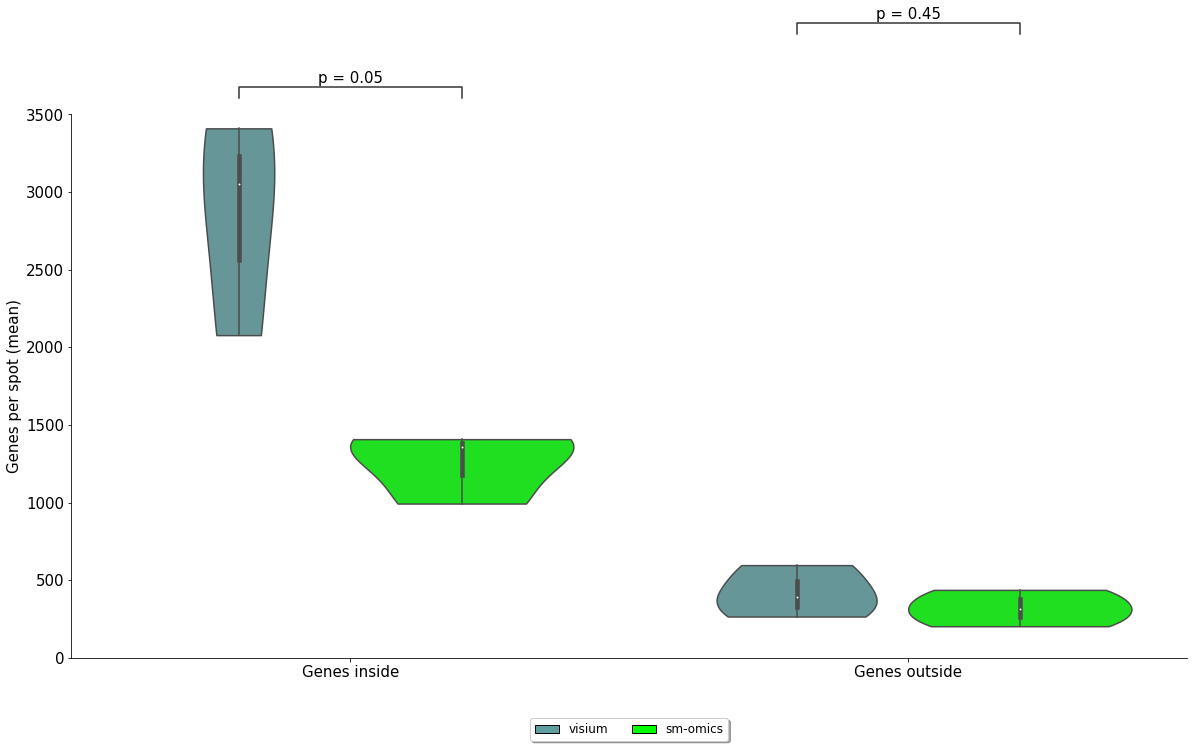

In [48]:
'Plots violin plots inside vs. outside tissue: Genes'
fig = plt.figure(figsize=(5, 5)) 

x='variable'
y='value'
hue = 'Condition'
data=dfplot

ax = sns.violinplot(x=x, y=y, data=data, hue=hue, order = ['Genes inside', 'Genes outside'], palette = ['cadetblue','lime', ], cut=0)

# change background color and figure borders
back_c = 'white'
ax.set_facecolor(back_c)
ax.grid(False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('k')
ax.spines['left'].set_color('k')

# X and y label size
ax.set_xlabel("")
ax.set_ylabel("Genes per spot (mean)", fontsize=15)
ax.set_ylim([0,3500])

# x and y ticks
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)

# Calculate Wilcoxons 
boxPairList = [(('Genes inside','sm-omics'), ('Genes inside','visium')),
               (('Genes outside','sm-omics'), ('Genes outside','visium'))]

add_stat_annotation(ax, data=data, x=x, y=y, hue=hue,
                    box_pairs=boxPairList,
                    test='ttest', text_format='simple', loc='outside', verbose=2, fontsize=15)

# Add patterns to distinuigh boxes
# hatch= ['////']
# for i, thisviolin in enumerate(ax.get_children()):
#     if isinstance(thisviolin, mpl.collections.PolyCollection):
#         if i in [2, 6]:
#             thisviolin.set_hatch(hatch =hatch[0])
#             thisviolin.set_edgecolor('k')
            
# Legend
handles, labels = ax.get_legend_handles_labels()
labels2 = ['sm-omics', 'visium',]
handles2 = handles[0:2]

inside_patch = mpatches.Patch( facecolor='cadetblue', label=labels2[1], edgecolor='k')
outside_patch= mpatches.Patch( facecolor='lime', label=labels2[0], edgecolor='k')
ax.legend(handles = [inside_patch, outside_patch],loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=2, fontsize=12)


fig.set_size_inches(20, 10)
plt.savefig("../../figures/SM_Visium_Genes.pdf", transparent=True, bbox_inches = 'tight',
   pad_inches = 0, dpi=1200)


In [17]:
data.groupby(['Condition', 'variable']).mean().round()

value
Condition variable             
sm-omics  Genes inside   1254.0
          Genes outside   319.0
visium    Genes inside   2845.0
          Genes outside   418.0

['UMIs inside', 'UMIs outside'] ['visium', 'sm-omics']
UMIs inside_sm-omics v.s. UMIs inside_visium: T-test P_val=3.127e-01 U_stat=-1.161e+00
UMIs outside_sm-omics v.s. UMIs outside_visium: T-test P_val=4.394e-01 U_stat=9.454e-01


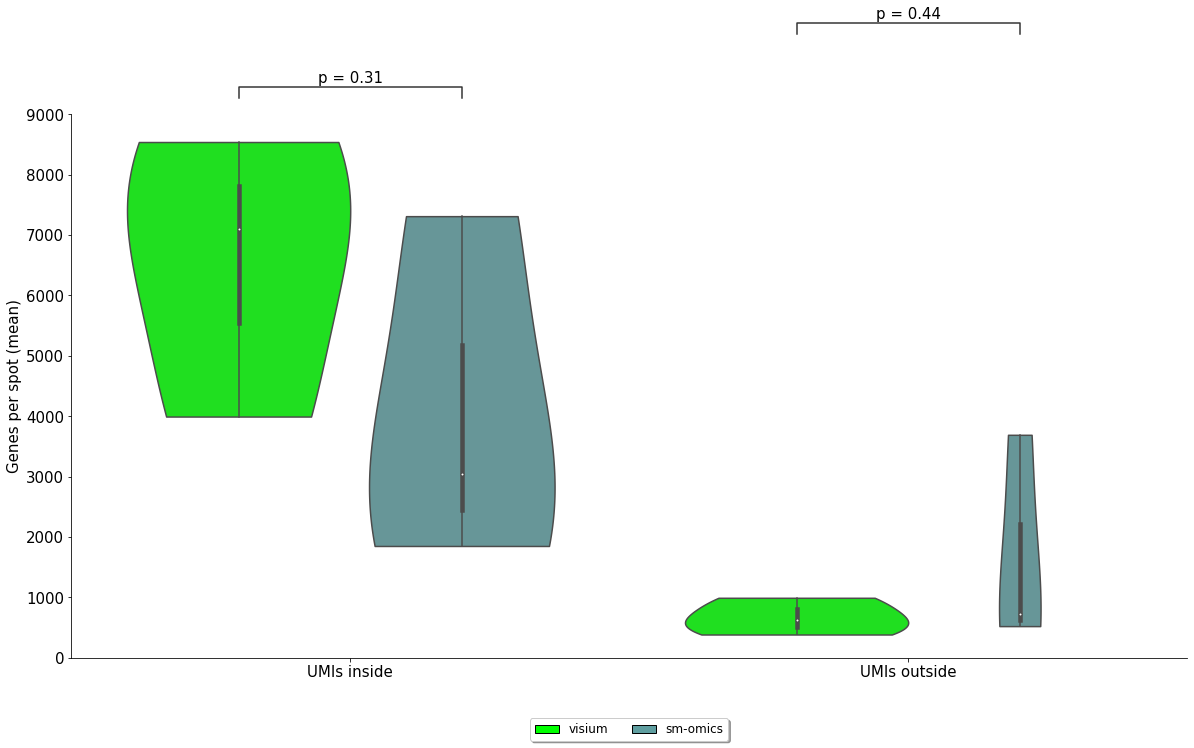

In [49]:
'Plots violin plots inside vs. outside tissue: Genes'
fig = plt.figure(figsize=(5, 5)) 

x='variable'
y='value'
hue = 'Condition'
data=dfplot_umi

ax = sns.violinplot(x=x, y=y, data=data, hue=hue, order = ['UMIs inside', 'UMIs outside'], palette = ['lime','cadetblue', ], cut=0)

# change background color and figure borders
back_c = 'white'
ax.set_facecolor(back_c)
ax.grid(False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('k')
ax.spines['left'].set_color('k')

# X and y label size
ax.set_xlabel("")
ax.set_ylabel("Genes per spot (mean)", fontsize=15)
ax.set_ylim([0,9000])

# x and y ticks
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)

# Calculate Wilcoxons 
boxPairList = [(('UMIs inside','sm-omics'), ('UMIs inside','visium')),
               (('UMIs outside','sm-omics'), ('UMIs outside','visium'))]

add_stat_annotation(ax, data=data, x=x, y=y, hue=hue,
                    box_pairs=boxPairList,
                    test='ttest', text_format='simple', loc='outside', verbose=2, fontsize=15)

# Add patterns to distinuigh boxes
# hatch= ['////']
# for i, thisviolin in enumerate(ax.get_children()):
#     if isinstance(thisviolin, mpl.collections.PolyCollection):
#         if i in [2, 6]:
#             thisviolin.set_hatch(hatch =hatch[0])
#             thisviolin.set_edgecolor('k')
            
# Legend
handles, labels = ax.get_legend_handles_labels()
labels2 = ['sm-omics', 'visium',]
handles2 = handles[0:2]

inside_patch = mpatches.Patch( facecolor='lime', label=labels2[1], edgecolor='k')
outside_patch= mpatches.Patch( facecolor='cadetblue', label=labels2[0], edgecolor='k')
ax.legend(handles = [inside_patch, outside_patch],loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=2, fontsize=12)


fig.set_size_inches(20, 10)
plt.savefig("../../figures/SM_Visium_UMIs.pdf", transparent=True, bbox_inches = 'tight',
   pad_inches = 0, dpi=1200)

In [41]:
data.groupby(['Condition', 'variable']).mean().round()

value
Condition variable            
sm-omics  UMIs inside   4067.0
          UMIs outside  1650.0
visium    UMIs inside   6544.0
          UMIs outside   669.0

In [13]:
data.groupby(['Condition', 'variable']).mean().round()

value
Condition variable            
sm-omics  UMIs inside   1254.0
          UMIs outside   319.0
visium    UMIs inside   2845.0
          UMIs outside   418.0

In [23]:
data.groupby(['Condition', 'variable']).std().round()

value
Condition variable            
ST        Genes inside   174.0
          Genes outside  120.0
sm-omics  Genes inside   168.0
          Genes outside   59.0

In [43]:
arr = list(data[(data['Condition'] == 'sm-omics') & (data['variable'] == 'Genes inside')]['value'])
mean = np.mean(arr)
sd = np.std(arr)

In [44]:
final_list = [x for x in arr if (x > mean - 2 * sd)]
print("within 2 stdevs: ", final_list)
final_list = [x for x in final_list if (x < mean + 2 * sd)]
print("within 2 stdevs: ", final_list)

within 2 stdevs:  [993.4391691394659, 1408.0516014234875, 1360.6618911174785]
within 2 stdevs:  [993.4391691394659, 1408.0516014234875, 1360.6618911174785]
